![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# PCA - Tarefa 01: *HAR* com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")
seed=5489456

In [2]:
filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels =   "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain =   "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain =   "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest =  "./Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest =   "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest =    "./Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [3]:
%%time
clf = DecisionTreeClassifier(random_state=seed).fit(X_train, y_train)
caminho = DecisionTreeClassifier(random_state=seed, min_samples_leaf=20).cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0.001])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)


Wall time: 2min 2s


## Árvore com PCA

Faça uma análise de componentes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

In [4]:
%%time
prcomp = PCA().fit(X_train) #não há variável resposta neste caso

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores  = [clf.score(X_test,  y_test)  for clf in clfs]
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]
acc_train = train_scores[ind_melhor_arvore]
acc_teste = melhor_arvore.score(X_test, y_test)
acuracia_teste = melhor_arvore.score(X_test, y_test)

print(f'X_train{X_train.shape}')
print(f'X_test{X_test.shape}')
print(f'pc_treino{pc_treino.shape}')
print(f'pc_teste{pc_teste.shape}')

X_train(7352, 561)
X_test(2947, 561)
pc_treino(7352, 561)
pc_teste(2947, 561)
Wall time: 932 ms


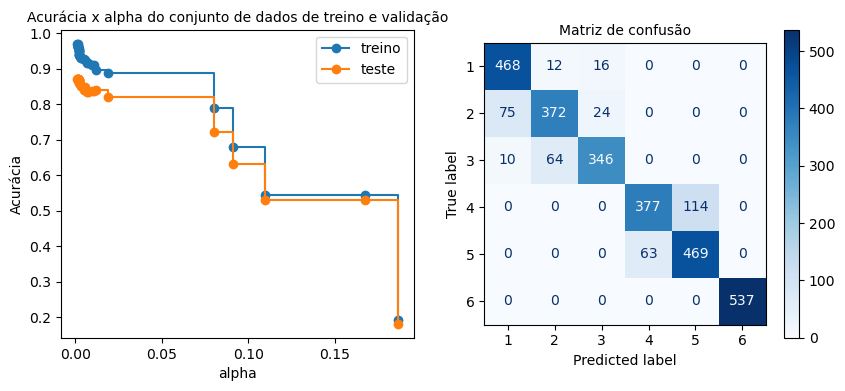

Acurácia da melhor árvore na base de treino:    96.8
Acurácia da melhor árvore na base de teste.:    87.2


In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Acurácia")
ax[0].set_title("Acurácia x alpha do conjunto de dados de treino e validação",fontsize = 10)
ax[0].plot(ccp_alphas, train_scores, marker='o', label="treino", drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores, marker='o', label="teste", drawstyle="steps-post")
ax[0].legend()

plot_confusion_matrix(melhor_arvore, X_test, y_test, ax=ax[1], cmap='Blues')
ax[1].set_title("Matriz de confusão",fontsize = 10)
plt.show()
print(f'Acurácia da melhor árvore na base de treino:    {acc_train*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste.:    {acc_teste*100:.1f}')

### Grid Search

In [ ]:
grid_parametros = {'ccp_alpha':ccp_alphas}
print(grid_parametros)

In [ ]:
%%time
grid = GridSearchCV(estimator = clf, 
                    param_grid=grid_parametros,
                    cv=5, 
                    verbose=3)
grid.fit(X_train, y_train) 

resultados = pd.DataFrame(grid.cv_results_)
print(f'Melhor score encontrado....: {round(grid.best_score_,6)}')
print(f'Melhor ccp_alpha encontrado: {resultados.iloc[grid.best_index_,4]}')
# resultados.sort_values('rank_test_score').head(1).T

In [ ]:
print(f'Melhor score encontrado....: {round(grid.best_score_,6)}')
print(f'Melhor ccp_alpha encontrado: {resultados.iloc[grid.best_index_,4]}')
resultados.sort_values('rank_test_score').head(1).T

In [ ]:
melhor_ccp = resultados.iloc[grid.best_index_,4]
clf = DecisionTreeClassifier(random_state=seed, ccp_alpha=melhor_ccp).fit(X_train, y_train)
acuracia2=clf.score(X_test, y_test)
acuracia_teste

## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento


In [6]:
t_exec = pd.DataFrame(columns=['componentes','acuracia','tempo'])

In [11]:
n=50
inicio = time.perf_counter()
colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)


clf = DecisionTreeClassifier(random_state=seed).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=seed, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_test, y_test) for clf in clfs]

ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {test_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

# melhor_arvore

fim = time.perf_counter()
tempo = fim - inicio
t_exec = t_exec.append({'componentes': n,
                        'acuracia':(melhor_arvore.score(pc_test, y_test)*100),
                        'tempo': tempo}, ignore_index=True)



Acurácia da melhor árvore na base de treino:    91.3
Acurácia da melhor árvore na base de validação: 82.9
Acurácia da melhor árvore na base de teste:     82.9


<IPython.core.display.Javascript object>


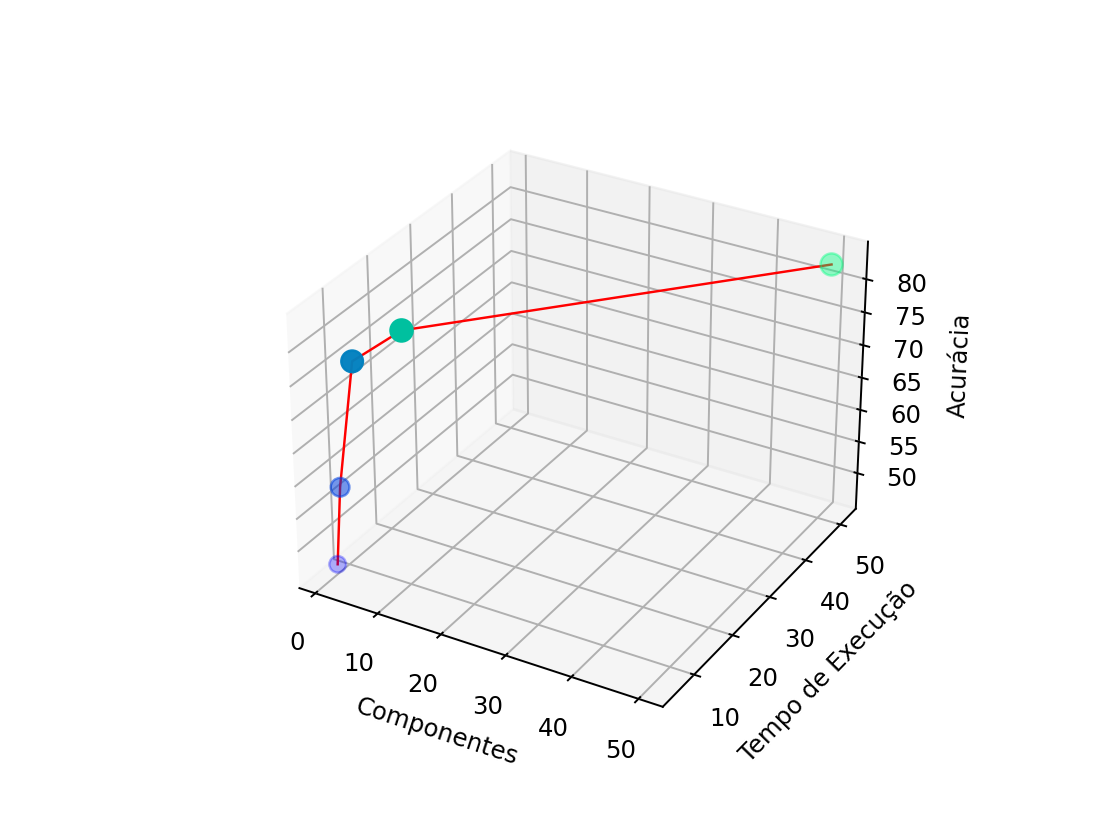

In [33]:
# Selecionando colunas de interesse
%matplotlib notebook
t_exec['classe']=(t_exec.index)+1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotando gráfico de dispersão
sc = ax.scatter(t_exec['componentes'], t_exec['tempo'], t_exec['acuracia'], 
                c=t_exec['classe'],
                cmap='winter',
                s=t_exec['acuracia'])

# Traçando linha unindo os pontos
ax.plot(t_exec['componentes'], t_exec['tempo'], t_exec['acuracia'], c='red', linewidth=1)

# Adicionando rótulos aos eixos
ax.set_xlabel('Componentes')
ax.set_ylabel('Tempo de Execução')
ax.set_zlabel('Acurácia')

# Exibindo gráfico
plt.show()

## Conclua

- O que aconteceu com a acurácia?
- O que aconteceu com o tempo de processamento?

In [34]:
t_exec[['classe','componentes','acuracia','tempo']].style.hide_index()

classe,componentes,acuracia,tempo
1,1.000000,46.929080,5.977344
2,2.000000,59.246692,5.849890
3,5.000000,79.131320,5.451268
4,10.000000,82.965728,9.457246
5,50.000000,82.863929,51.218846


### Conclusão
- A acurácia aumentou à medida que o número de componentes também aumentava;
- Em contrapartida, o tempo de execução também aumentou à medida que foi sendo incrementado o número de componentes;
- Em uma análise apressada poderia-se até concluir que quanto maior o número de componentes maior a acurácia e mais tempo de execução. No entanto essa observação pode ser entendida como regra geral, sendo verdadeira até certo ponto somente. 
- Após este ponto, percebe-se que o excesso de componentes começa a atrapalhar, gastando-se muito mais tempo na execução para obter-se um resultado até mesmo inferior ao anterior.